In [ ]:

import os

import numpy as np
import pandas as pd
import joblib
import cloudpickle
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from scipy.stats import ks_2samp

In [ ]:

# ---------------- CONFIG ----------------
figs_folder = '../artifacts'
os.makedirs(figs_folder, exist_ok=True)

saved_folder = 'regression_package'

MODEL_PATH = os.path.join(saved_folder,"model.pkl")
PREPROCESSOR_PATH = os.path.join(saved_folder,"pipeline.pkl")
REFERENCE_DATA_PATH = os.path.join(saved_folder,"X_rest.pkl")  
REFERENCE_TARGET_PATH = os.path.join(saved_folder,"Y_rest.pkl")  
UNSEEN_DATA_PATH = os.path.join(saved_folder,"X_test.pkl")
UNSEEN_TARGET_PATH = os.path.join(saved_folder,"Y_test.pkl")


# Load
with open(PREPROCESSOR_PATH, 'rb') as f:
    preprocessor = cloudpickle.load(f)
model = joblib.load(MODEL_PATH)

print("Loading unseen data...")
X_test = joblib.load(UNSEEN_DATA_PATH)
Y_test = joblib.load(UNSEEN_TARGET_PATH)

Loading unseen data...


In [12]:
# ---------------- PREPROCESS ----------------

print("Applying preprocessing...")
X_test_transformed = preprocessor.transform(X_test)


# ---------------- PREDICT ----------------

print("Generating predictions...")
y_pred = model.predict(X_test_transformed)

Applying preprocessing...
Generating predictions...


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [13]:
# Evaluation metrics
r2 = r2_score(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
mae = mean_absolute_error(Y_test, y_pred)

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test R²: -2.5389
Test RMSE: 2164.6070
Test MAE: 1917.6191


In [14]:
reference_df = joblib.load(REFERENCE_DATA_PATH)

numeric_cols = X_test.select_dtypes(include=[np.number]).columns

psi_results = {}
ks_results = {}

for col in numeric_cols:
    ref = reference_df[col].dropna()
    new = X_test[col].dropna()
    
    # PSI
    bins = pd.qcut(ref, q=10, duplicates="drop")
    ref_dist = bins.value_counts(normalize=True)
    new_bins = pd.cut(new, bins=bins.cat.categories)
    new_dist = new_bins.value_counts(normalize=True)
    
    # Align distributions to avoid NaNs
    ref_dist, new_dist = ref_dist.align(new_dist, fill_value=1e-6)
    
    psi = sum((new_dist - ref_dist) * np.log(new_dist / ref_dist))
    psi_results[col] = psi
    
    # KS
    ks_stat, ks_p = ks_2samp(ref, new)
    ks_results[col] = {"ks_stat": ks_stat, "p_value": ks_p}

drift_summary = pd.DataFrame({
    "Feature": psi_results.keys(),
    "PSI": psi_results.values(),
    "KS_Stat": [ks_results[col]["ks_stat"] for col in psi_results.keys()],
    "KS_p_value": [ks_results[col]["p_value"] for col in psi_results.keys()]
})

# Sort by PSI
drift_summary = drift_summary.sort_values(by="PSI", ascending=False)
print(drift_summary)

          Feature       PSI   KS_Stat  KS_p_value
5   Documentation  0.428216  0.166520    0.132162
0    Availability  0.205369  0.121859    0.451854
2  Successability  0.135995  0.103501    0.655568
3     Reliability  0.100660  0.107620    0.608398
1      Throughput  0.077234  0.069079    0.965831
4  Best Practices  0.072199  0.054016    0.997803


C:\Users\asaraiva\AppData\Local\Temp\ipykernel_21904\1368718390.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="PSI", y="Feature", data=drift_summary, palette="Blues_r")


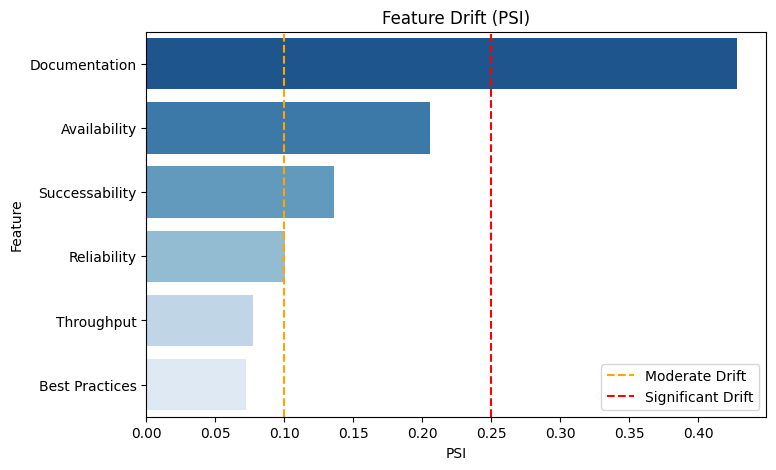

C:\Users\asaraiva\AppData\Local\Temp\ipykernel_21904\1368718390.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="KS_Stat", y="Feature", data=drift_summary, palette="Greens_r")


<Figure size 640x480 with 0 Axes>

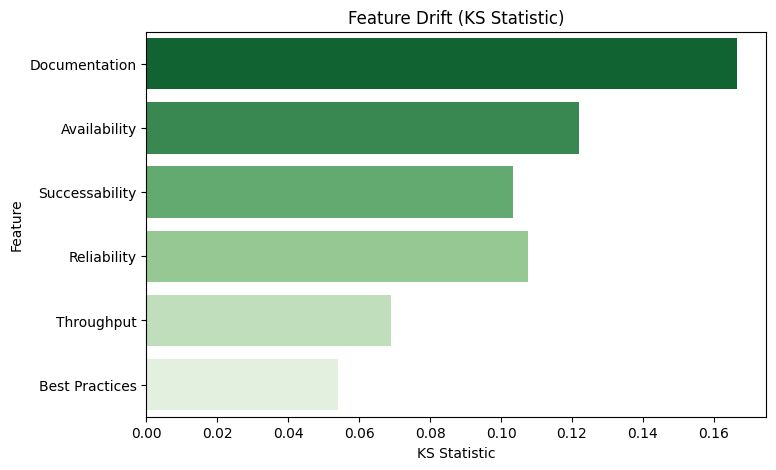

<Figure size 640x480 with 0 Axes>

In [15]:
# Add interpretation column
def classify_psi(psi):
    if psi < 0.1:
        return "No Drift"
    elif psi < 0.25:
        return "Moderate Drift"
    else:
        return "Significant Drift"

drift_summary["Drift_Level"] = drift_summary["PSI"].fillna(0).apply(classify_psi)

# PSI Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x="PSI", y="Feature", data=drift_summary, palette="Blues_r")
plt.axvline(0.1, color="orange", linestyle="--", label="Moderate Drift")
plt.axvline(0.25, color="red", linestyle="--", label="Significant Drift")
plt.title("Feature Drift (PSI)")
plt.xlabel("PSI")
plt.ylabel("Feature")
plt.legend()
plt.show()

plt.savefig(os.path.join(figs_folder, "regression_PSI.png"))

# KS Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x="KS_Stat", y="Feature", data=drift_summary, palette="Greens_r")
plt.title("Feature Drift (KS Statistic)")
plt.xlabel("KS Statistic")
plt.ylabel("Feature")
plt.show()

plt.savefig(os.path.join(figs_folder, "regression_KS_stats.png"))